In [1]:
import os
import sys
import numpy as np
import re
import cv2 as op
import matplotlib.pyplot as plt
import tensorflow as tf
from os import listdir
from tensorflow.keras.layers import *
from time import time
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import Model
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.xception import Xception
import pandas as pd
import shutil


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DATASET_PATH = r'/content/drive/MyDrive/datasets/Massachusetts Buildings Dataset/png'
TRAIN_IMG_DIR = os.path.join(DATASET_PATH, 'train')
TRAIN_MASK_DIR = os.path.join(DATASET_PATH, 'train_labels')

VAL_IMG_DIR = os.path.join(DATASET_PATH, 'val')
VAL_MASK_DIR = os.path.join(DATASET_PATH, 'val_labels')

TEST_IMG_DIR = os.path.join(DATASET_PATH, 'test')
TEST_MASK_DIR = os.path.join(DATASET_PATH, 'test_labels')

print("train Images:", len(os.listdir(TRAIN_IMG_DIR)))
print("train Masks :", len(os.listdir(TRAIN_MASK_DIR)))
print("val Images  :", len(os.listdir(VAL_IMG_DIR)))
print("val Masks   :", len(os.listdir(VAL_MASK_DIR)))
print("test Images :", len(os.listdir(TEST_IMG_DIR)))
print("test Masks  :", len(os.listdir(TEST_MASK_DIR)))


train Images: 137
train Masks : 137
val Images  : 4
val Masks   : 4
test Images : 10
test Masks  : 10


In [4]:
import cv2

def load_and_preprocess(image_path, mask_path, img_size=256):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size)) / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (img_size, img_size))
    mask = np.where(mask > 127, 1, 0)
    return img, mask

def visualize_samples(img_dir, mask_dir, title):
    img_files = sorted([os.path.join(img_dir, x) for x in os.listdir(img_dir) if x.endswith(('.tif', '.tiff', '.png', '.jpg'))])
    mask_files = sorted([os.path.join(mask_dir, x) for x in os.listdir(mask_dir) if x.endswith(('.tif', '.tiff', '.png', '.jpg'))])

    for i in range(2):
        img, mask = load_and_preprocess(img_files[i], mask_files[i])

        plt.figure(figsize=(8, 4))
        plt.suptitle(f"{title} Sample {i+1}")

        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title("Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Mask")
        plt.axis('off')

        plt.show()

visualize_samples(TRAIN_IMG_DIR, TRAIN_MASK_DIR, "Train")
visualize_samples(VAL_IMG_DIR, VAL_MASK_DIR, "Validation")
visualize_samples(TEST_IMG_DIR, TEST_MASK_DIR, "Test")


Output hidden; open in https://colab.research.google.com to view.

In [5]:
import cv2

IMG_SIZE = 256
BATCH_SIZE = 8

def load_image_and_mask_numpy(image_path, mask_path):
    image_path = image_path.decode()
    mask_path = mask_path.decode()

    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = (mask > 127).astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)

    return img.astype(np.float32), mask

def load_image_and_mask(image_path, mask_path):
    img, mask = tf.numpy_function(
        load_image_and_mask_numpy,
        [image_path, mask_path],
        [tf.float32, tf.float32]
    )
    img.set_shape([IMG_SIZE, IMG_SIZE, 3])
    mask.set_shape([IMG_SIZE, IMG_SIZE, 1])
    return img, mask

def get_file_lists(img_dir, mask_dir):
    img_files = sorted([
        os.path.join(img_dir, fname)
        for fname in os.listdir(img_dir)
        if fname.endswith('.png')
    ])
    mask_files = sorted([
        os.path.join(mask_dir, fname)
        for fname in os.listdir(mask_dir)
        if fname.endswith('.png')
    ])
    return img_files, mask_files

train_imgs, train_masks = get_file_lists(TRAIN_IMG_DIR, TRAIN_MASK_DIR)
val_imgs, val_masks = get_file_lists(VAL_IMG_DIR, VAL_MASK_DIR)
test_imgs, test_masks = get_file_lists(TEST_IMG_DIR, TEST_MASK_DIR)

print(f"Train: {len(train_imgs)} images, {len(train_masks)} masks")
print(f"Val  : {len(val_imgs)} images, {len(val_masks)} masks")
print(f"Test : {len(test_imgs)} images, {len(test_masks)} masks")

def create_dataset(img_list, mask_list, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((img_list, mask_list))
    dataset = dataset.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=50)
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

train_ds = create_dataset(train_imgs, train_masks, shuffle=True)
val_ds = create_dataset(val_imgs, val_masks)
test_ds = create_dataset(test_imgs, test_masks)

print(" Datasets are ready for training with U-Net.")


Train: 137 images, 137 masks
Val  : 4 images, 4 masks
Test : 10 images, 10 masks
 Datasets are ready for training with U-Net.


In [6]:

from tensorflow.keras import layers, models

def unet_model(input_size=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = layers.Input(input_size)

    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return 1 - dice

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dl = dice_loss(y_true, y_pred)
    return bce + dl

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_pred_bin = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred_bin)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred_bin) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=bce_dice_loss,
    metrics=[iou_metric, tf.keras.metrics.BinaryAccuracy()]
)

print("Model compiled successfully and ready for training!")


Model compiled successfully and ready for training!


Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.7655 - iou_metric: 0.0274 - loss: 1.4383
Epoch 1: val_iou_metric improved from -inf to 0.00000, saving model to best_unet_roads.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 155s 5s/step - binary_accuracy: 0.7693 - iou_metric: 0.0264 - loss: 1.4359 - val_binary_accuracy: 0.8914 - val_iou_metric: 3.5120e-11 - val_loss: 1.3007 - learning_rate: 1.0000e-04
Epoch 2/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - binary_accuracy: 0.8687 - iou_metric: 1.5027e-11 - loss: 1.3018
Epoch 2: val_iou_metric did not improve from 0.00000
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 570ms/step - binary_accuracy: 0.8686 - iou_metric: 1.5385e-11 - loss: 1.3018 - val_binary_accuracy: 0.8914 - val_iou_metric: 3.5120e-11 - val_loss: 1.2934 - learning_rate: 1.0000e-04
Epoch 3/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - binary_accuracy: 0.8638 - iou_metric: 1.4881e-11 - loss: 1.2952
Epoch 3: val_iou_metric did not improve from 0.00000
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 624ms/step - binary_accuracy: 0.8640 - iou_metric: 1.5331e-11 - loss: 1.2953 - val_binary_accuracy: 0.8914 - val_iou_metric: 3.5120e-11 - val_loss: 1.2800 - learning_rate: 1.0000e-04
Epoch 4/25
18/18 ━━━━━

18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 664ms/step - binary_accuracy: 0.8645 - iou_metric: 4.8405e-05 - loss: 1.1607 - val_binary_accuracy: 0.8914 - val_iou_metric: 6.6697e-04 - val_loss: 1.0952 - learning_rate: 1.0000e-04
Epoch 8/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - binary_accuracy: 0.8586 - iou_metric: 7.8626e-04 - loss: 1.1300
Epoch 8: val_iou_metric improved from 0.00067 to 0.02082, saving model to best_unet_roads.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 749ms/step - binary_accuracy: 0.8591 - iou_metric: 7.9880e-04 - loss: 1.1288 - val_binary_accuracy: 0.8927 - val_iou_metric: 0.0208 - val_loss: 1.0839 - learning_rate: 1.0000e-04
Epoch 9/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - binary_accuracy: 0.8667 - iou_metric: 0.0305 - loss: 1.1218
Epoch 9: val_iou_metric improved from 0.02082 to 0.04519, saving model to best_unet_roads.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 760ms/step - binary_accuracy: 0.8668 - iou_metric: 0.0306 - loss: 1.1210 - val_binary_accuracy: 0.8937 - val_iou_metric: 0.0452 - val_loss: 1.0595 - learning_rate: 1.0000e-04
Epoch 10/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - binary_accuracy: 0.8679 - iou_metric: 0.0820 - loss: 1.0970
Epoch 10: val_iou_metric improved from 0.04519 to 0.13857, saving model to best_unet_roads.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 740ms/step - binary_accuracy: 0.8680 - iou_metric: 0.0823 - loss: 1.0968 - val_binary_accuracy: 0.8948 - val_iou_metric: 0.1386 - val_loss: 1.0475 - learning_rate: 1.0000e-04
Epoch 11/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - binary_accuracy: 0.8719 - iou_metric: 0.1445 - loss: 1.0824
Epoch 11: val_iou_metric did not improve from 0.13857
18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 647ms/step - binary_accuracy: 0.8718 - iou_metric: 0.1431 - loss: 1.0820 - val_binary_accuracy: 0.8955 - val_iou_metric: 0.0889 - val_loss: 1.0364 - learning_rate: 1.0000e-04
Epoch 12/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - binary_accuracy: 0.8726 - iou_metric: 0.1413 - loss: 1.0477
Epoch 12: val_iou_metric improved from 0.13857 to 0.18346, saving model to best_unet_roads.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 688ms/step - binary_accuracy: 0.8723 - iou_metric: 0.1424 - loss: 1.0478 - val_binary_accuracy: 0.8903 - val_iou_metric: 0.1835 - val_loss: 1.0109 - learning_rate: 1.0000e-04
Epoch 13/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - binary_accuracy: 0.8540 - iou_metric: 0.2059 - loss: 1.0541
Epoch 13: val_iou_metric improved from 0.18346 to 0.18725, saving model to best_unet_roads.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 739ms/step - binary_accuracy: 0.8545 - iou_metric: 0.2054 - loss: 1.0534 - val_binary_accuracy: 0.8910 - val_iou_metric: 0.1872 - val_loss: 0.9965 - learning_rate: 1.0000e-04
Epoch 14/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - binary_accuracy: 0.8610 - iou_metric: 0.2034 - loss: 1.0256
Epoch 14: val_iou_metric improved from 0.18725 to 0.24885, saving model to best_unet_roads.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 661ms/step - binary_accuracy: 0.8611 - iou_metric: 0.2038 - loss: 1.0255 - val_binary_accuracy: 0.8772 - val_iou_metric: 0.2488 - val_loss: 0.9786 - learning_rate: 1.0000e-04
Epoch 15/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - binary_accuracy: 0.8579 - iou_metric: 0.2263 - loss: 1.0183
Epoch 15: val_iou_metric improved from 0.24885 to 0.26263, saving model to best_unet_roads.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 747ms/step - binary_accuracy: 0.8580 - iou_metric: 0.2257 - loss: 1.0186 - val_binary_accuracy: 0.8668 - val_iou_metric: 0.2626 - val_loss: 0.9860 - learning_rate: 1.0000e-04
Epoch 16/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - binary_accuracy: 0.8500 - iou_metric: 0.2427 - loss: 1.0230
Epoch 16: val_iou_metric did not improve from 0.26263
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 587ms/step - binary_accuracy: 0.8506 - iou_metric: 0.2413 - loss: 1.0227 - val_binary_accuracy: 0.8891 - val_iou_metric: 0.2338 - val_loss: 0.9601 - learning_rate: 1.0000e-04
Epoch 17/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - binary_accuracy: 0.8650 - iou_metric: 0.2444 - loss: 0.9858
Epoch 17: val_iou_metric did not improve from 0.26263
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 676ms/step - binary_accuracy: 0.8648 - iou_metric: 0.2439 - loss: 0.9865 - val_binary_accuracy: 0.8877 - val_iou_metric: 0.2392 - val_loss: 0.9537 - learning_rate: 1.0000e-04
Epoch 18/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 63

18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 730ms/step - binary_accuracy: 0.8626 - iou_metric: 0.2575 - loss: 0.9790 - val_binary_accuracy: 0.8832 - val_iou_metric: 0.2739 - val_loss: 0.9296 - learning_rate: 1.0000e-04
Epoch 22/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - binary_accuracy: 0.8564 - iou_metric: 0.2642 - loss: 0.9751
Epoch 22: val_iou_metric did not improve from 0.27394
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 578ms/step - binary_accuracy: 0.8568 - iou_metric: 0.2637 - loss: 0.9751 - val_binary_accuracy: 0.8933 - val_iou_metric: 0.2528 - val_loss: 0.9230 - learning_rate: 1.0000e-04
Epoch 23/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - binary_accuracy: 0.8596 - iou_metric: 0.2559 - loss: 0.9779
Epoch 23: val_iou_metric improved from 0.27394 to 0.28180, saving model to best_unet_roads.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 726ms/step - binary_accuracy: 0.8599 - iou_metric: 0.2560 - loss: 0.9775 - val_binary_accuracy: 0.8865 - val_iou_metric: 0.2818 - val_loss: 0.9167 - learning_rate: 1.0000e-04
Epoch 24/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - binary_accuracy: 0.8556 - iou_metric: 0.2613 - loss: 0.9866
Epoch 24: val_iou_metric did not improve from 0.28180
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 608ms/step - binary_accuracy: 0.8562 - iou_metric: 0.2612 - loss: 0.9856 - val_binary_accuracy: 0.8927 - val_iou_metric: 0.2584 - val_loss: 0.9214 - learning_rate: 1.0000e-04
Epoch 25/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - binary_accuracy: 0.8666 - iou_metric: 0.2727 - loss: 0.9545
Epoch 25: val_iou_metric improved from 0.28180 to 0.29628, saving model to best_unet_roads.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 710ms/step - binary_accuracy: 0.8666 - iou_metric: 0.2719 - loss: 0.9550 - val_binary_accuracy: 0.8808 - val_iou_metric: 0.2963 - val_loss: 0.9153 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 25.


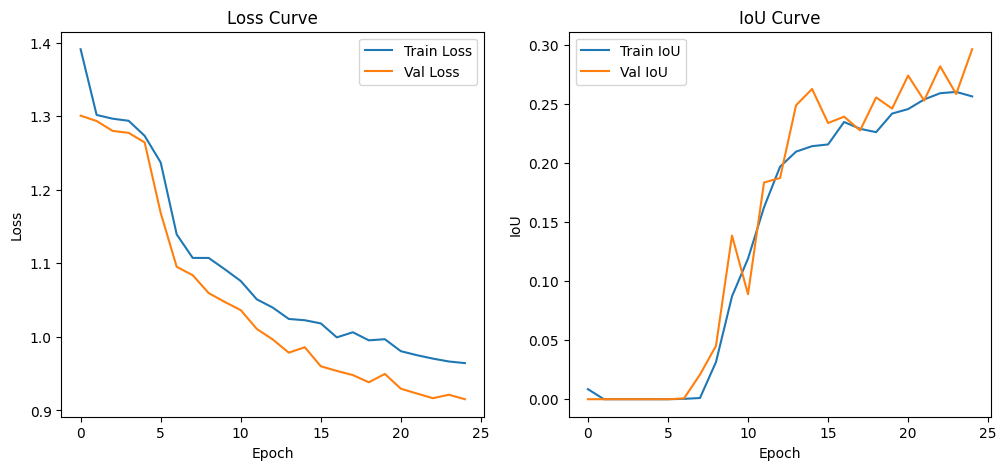

In [8]:

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_unet_roads.h5',
    monitor='val_iou_metric',
    mode='max',
    save_best_only=True,
    verbose=1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_iou_metric',
    mode='max',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['iou_metric'], label='Train IoU')
plt.plot(history.history['val_iou_metric'], label='Val IoU')
plt.title('IoU Curve')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.show()


In [9]:

model.load_weights('best_unet_roads.h5')

results = model.evaluate(test_ds, verbose=1)
print(f"\nTest Results:")
print(f"Loss         : {results[0]:.4f}")
print(f"IoU          : {results[1]:.4f}")
print(f"Accuracy     : {results[2]:.4f}")

def visualize_predictions(dataset, num_samples=5):
    for imgs, masks in dataset.take(1):
        preds = model.predict(imgs)
        preds_bin = preds > 0.5

        for i in range(num_samples):
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.imshow(imgs[i])
            plt.title("Input Image")
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(masks[i, :, :, 0], cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(preds_bin[i, :, :, 0], cmap='gray')
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.show()

visualize_predictions(test_ds, num_samples=5)


Output hidden; open in https://colab.research.google.com to view.

In [10]:
# history2 = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=history.epoch[-1] + 25,
#     initial_epoch=history.epoch[-1] + 1,
#     callbacks=[checkpoint, early_stop, reduce_lr]
# )


In [11]:
# history3 = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=history.epoch[-1] + 15,
#     initial_epoch=history.epoch[-1] + 1,
#     callbacks=[checkpoint, early_stop, reduce_lr]
# )


In [12]:
model.load_weights('best_unet_roads.h5')
results = model.evaluate(test_ds, verbose=1)
print(f"\nTest Results:")
print(f"Loss         : {results[0]:.4f}")
print(f"IoU          : {results[1]:.4f}")
print(f"Accuracy     : {results[2]:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - binary_accuracy: 0.8075 - iou_metric: 0.3200 - loss: 0.9922

Test Results:
Loss         : 0.9849
IoU          : 0.3222
Accuracy     : 0.8129


In [13]:
visualize_predictions(test_ds, num_samples=5)


Output hidden; open in https://colab.research.google.com to view.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
Confusion Matrix:
[[475720  57743]
 [ 64883  57014]]

Metrics on Test Set:
Precision     : 0.4968
Recall        : 0.4677
F1 Score      : 0.4818
Dice Coefficient: 0.4818
IoU (calculated): 0.3174


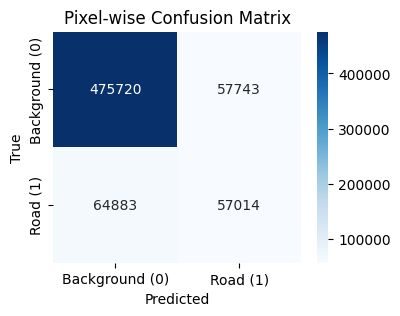

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

y_true_list = []
y_pred_list = []

threshold = 0.5

for images, masks in test_ds:
    preds = model.predict(images)
    preds_bin = (preds > threshold).astype(np.uint8)
    y_true_list.append(masks.numpy().flatten())
    y_pred_list.append(preds_bin.flatten())

y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)

cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
dice = 2 * tp / (2 * tp + fp + fn)
iou = tp / (tp + fp + fn)

print(f"Confusion Matrix:\n{cm}")
print(f"\nMetrics on Test Set:")
print(f"Precision     : {precision:.4f}")
print(f"Recall        : {recall:.4f}")
print(f"F1 Score      : {f1:.4f}")
print(f"Dice Coefficient: {dice:.4f}")
print(f"IoU (calculated): {iou:.4f}")

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Background (0)', 'Road (1)'],
            yticklabels=['Background (0)', 'Road (1)'])
plt.title("Pixel-wise Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [15]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score, accuracy_score, cohen_kappa_score
import time

model = tf.keras.models.load_model('best_unet_roads.h5', custom_objects={'iou_metric': iou_metric}, compile=False)

y_true = []
y_pred = []

start = time.time()
for images, masks in test_ds:
    preds = model.predict(images)
    preds = (preds > 0.5).astype(np.uint8)
    y_true.append(masks.numpy().flatten())
    y_pred.append(preds.flatten())
end = time.time()

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
iou = jaccard_score(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)

params = model.count_params()


prediction_time = (end - start) / len(test_imgs)

print("Precision:", round(precision,4))
print("Recall:", round(recall,4))
print("F1 Score:", round(f1,4))
print("IoU:", round(iou,4))
print("Accuracy:", round(acc,4))
print("Kappa:", round(kappa,4))
print("Parameters:", params)
print("Prediction Time (s/img):", round(prediction_time,4))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
Precision: 0.4968
Recall: 0.4677
F1 Score: 0.4818
IoU: 0.3174
Accuracy: 0.8129
Kappa: 0.3678
Parameters: 31031745
Prediction Time (s/img): 0.2952
